In [1]:
#necessary module
import os ; import sys
sys.path.append(os.getcwd()+"/Equantum")
#path to data
datapath="/scratch/zhaoyuha/Datas/EQuantum_data/topgate/"
setuppath="setup/dotgate/"
from sites import Site
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from fsc import FSC
import scipy.linalg as sl
import scipy.constants as sc
import importlib
import poissonsolver as psolver
import kwant
import scipy.io as sio
%matplotlib widget

from EQsystem import System

In [2]:
import fsc
importlib.reload(fsc)
from fsc import FSC

import EQsystem
importlib.reload(EQsystem)
from EQsystem import System
#test module
import solvers
importlib.reload(solvers)
from solvers import local_solver

from scipy.interpolate import interp1d
from scipy.optimize import brentq

import poissonsolver
importlib.reload(poissonsolver)

<module 'poissonsolver' from '/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/poissonsolver.py'>

In [3]:
import qbuilder
importlib.reload(qbuilder)
import poissonsolver
importlib.reload(poissonsolver)

<module 'poissonsolver' from '/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/poissonsolver.py'>

## Define system

In [4]:
def density_function(r):
        spacing0 = 0.01 # spacing at r=0
        k = 1  # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

In [110]:
geoparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [5]:
geoparams={"lattice_type": "honeycomb",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

## Initialize System

In [112]:
syst=System(geoparams)
syst.export_sites(filename=setuppath+"sites.json")

Generated 106128 points in 3D.
Voronoi cells have been created.
0 sites have been removed from the system.
EQsystem is successfully initialized.


In [6]:
config_file=setuppath+"001_1_hc.json"
syst=System(geoparams,config_file=config_file,ifqsystem=True,quantum_builder="default")

Generated 15915 points in 3D.
Voronoi cells have been created.
0 sites have been removed from the system.
Quantum system is generated using default.
EQsystem is successfully initialized.


In [7]:
qparams={'Ufunc': lambda x:0,'phi':0.1}
fsc=FSC(syst,ifinitial=False,params=qparams)

The quantum problem has been initialized.


In [8]:
fsc.update_BC(syst,'gate','potential',0.3)
fsc.update_BC(syst,'backgate','potential',-0.2,ifinitial=True)

The poisson problem has been initialized.


## Check the Spectrum

In [122]:
ltest=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,2000),TFapprox=False,ifpara=True,Ncore=20)

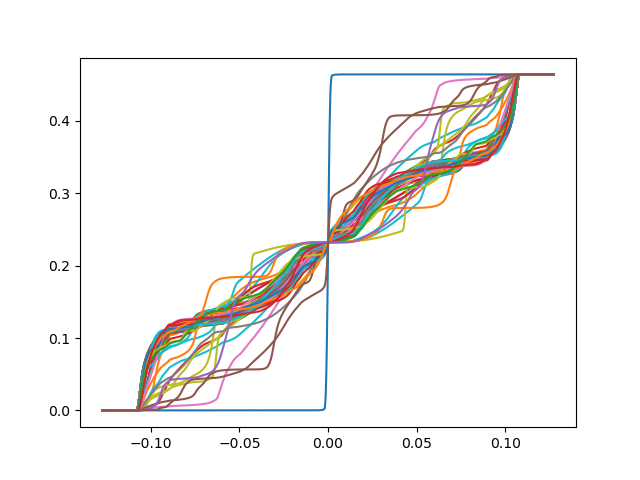

In [128]:
plt.figure()
#plt.plot(ltest[1][0],ltest[1][1])
for ii in range(0,len(fsc.Qsites),20):
    plt.plot(ltest[ii][0],[np.sum(ltest[ii][1][:idx]) for idx in range(len(ltest[ii][0]))])
plt.show()

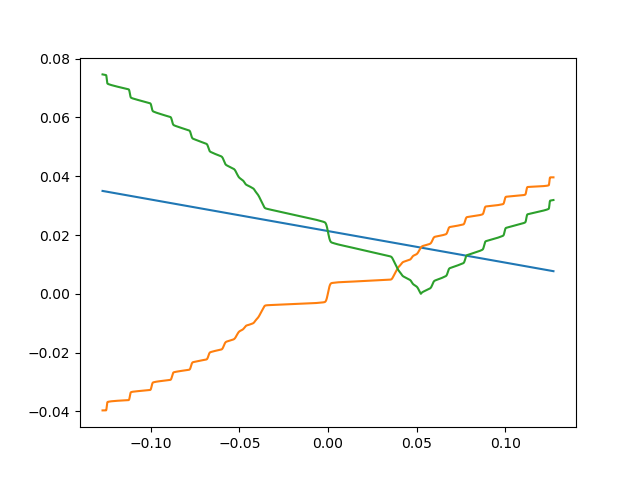

In [46]:
sidx=200
ni=fsc.ni[fsc.Qprime][sidx]
Ci=fsc.Ci[sidx]
ildos=fsc.ildos[sidx]
Ui=fsc.Ui[fsc.Qprime][sidx]

x_dis=ildos[0]-Ui
y_dis=ildos[1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]
ildos_dis=ildos_dis-fsc.max_fill/2
ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')
def dn_for_Ci(dU):
    return -dU*Ci+ni
def diff(dU):
    return np.abs(dn_for_Ci(dU)-ildos_iterp(dU))

dUs=np.linspace(-5,5,200)*fsc.t
plt.figure()
plt.plot(x_dis,[dn_for_Ci(dU) for dU in x_dis])
plt.plot(x_dis,[ildos_iterp(dU) for dU in x_dis])
plt.plot(x_dis,[diff(dU) for dU in x_dis])
#plt.ylim((-0.05,0.05))
#plt.xlim((-0.03,0.03))
#plt.plot(x_dis,ildos_dis)
#plt.plot(fsc.ildos[0][0],fsc.ildos[0][1])
plt.show()

In [118]:
Htest=fsc.qsystem.H.toarray()
pot=np.diagonal(Htest)

In [119]:
ev=np.sort(sl.eigvals(Htest))

In [120]:
ildos=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-2.9*fsc.t,2.9*fsc.t,2000),
npol_scale=6)

/tmp/ipykernel_509177/1861956384.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


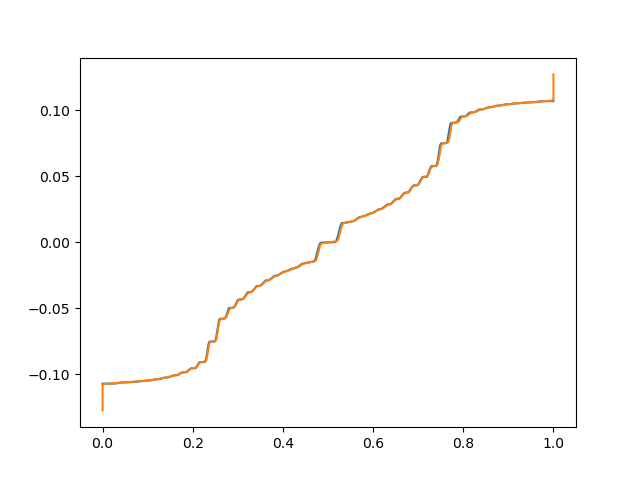

In [121]:
nden=np.array([np.sum(ildos[0][1][:idx])for idx,ee in enumerate(ildos[0][0])])
plt.figure()
plt.plot(np.linspace(0,1,len(ev)),ev)
plt.plot(nden/nden[-1],ildos[0][0])
plt.show()

## Plot System

/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/EQsystem.py:242: RuntimeWarning: invalid value encountered in true_divide
  alphamap=np.abs(prop_values/(1.5*(np.max(prop_values)-np.min(prop_values))))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


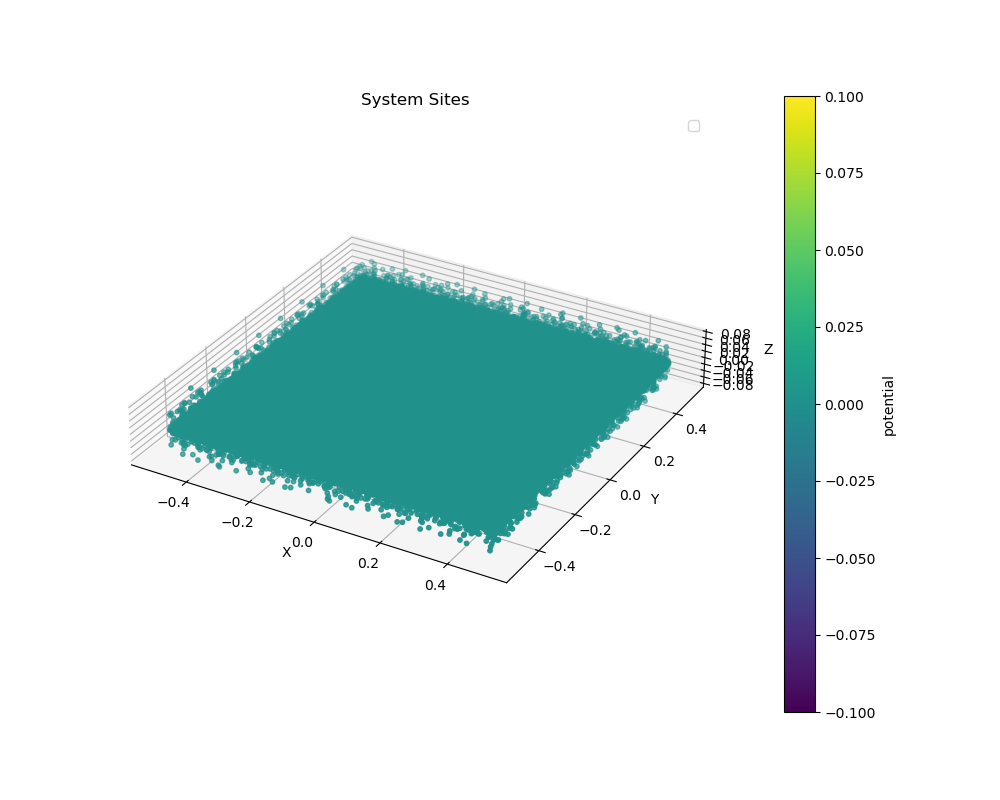

In [15]:
syst.plot_geometry("potential")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


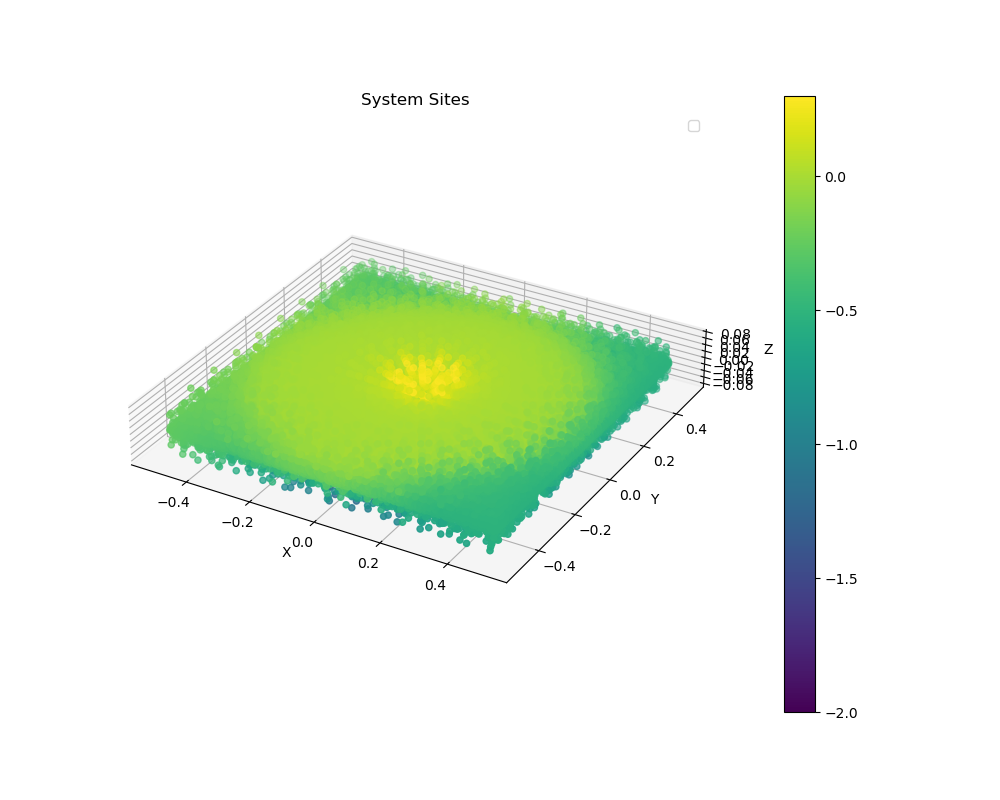

In [16]:
indicate=np.zeros(len(fsc.sites))
indicate[fsc.D_indices]=1
fsc.plot_full(fsc.Ui)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


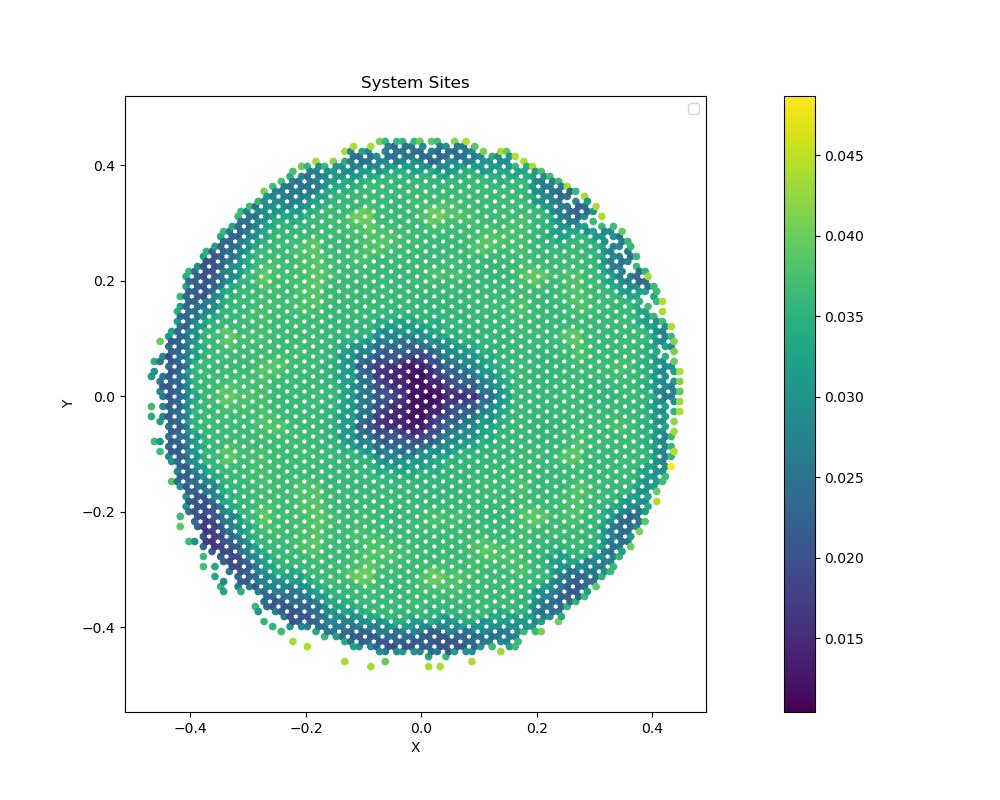

In [52]:
indicate=np.zeros(len(fsc.Qsites))
#indicate[1335]=1
plotdata=fsc.ni[fsc.Qsites]
#plotdata=dUdn[1]
#plotdata=pot
fsc.plot_qsystem(plotdata)

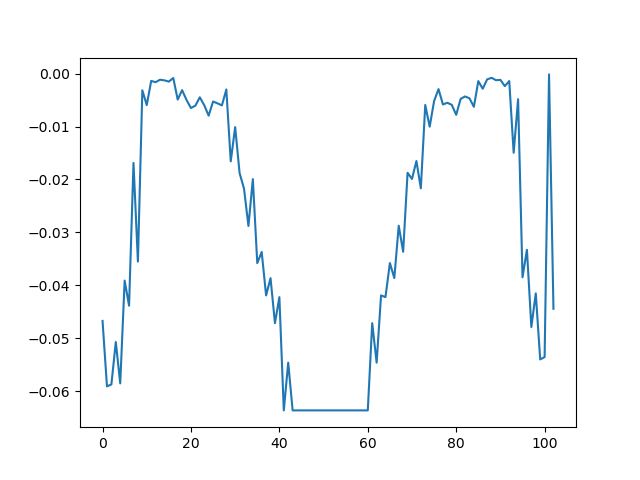

In [51]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.003 and fsc.sites[idx].material=='Qsystem']
plt.figure()
plt.plot(fsc.Ui[cut_idx])
plt.show()

## Solve FSC

In [ ]:
fsc.solve(syst,save=datapath+"test")

In [9]:
fsc.local_solver()

-0.02177161450286251 0.0036619093761486427


In [27]:
import quantum_solvers
importlib.reload(quantum_solvers)
from quantum_solvers import default_solver

In [10]:
center = np.array([0.,0.,0.])
site_radii=[]
for site in fsc.qsystem.Qsites:
    coord = np.array(site.coordinates)
    # Compute radial distance in x-y plane relative to center
    r = np.linalg.norm(coord[:2] - center[:2])
    site_radii.append(r)

In [13]:
site_radii = np.array(site_radii)      
# Define radial bins (n+1 bin edges for n bins)
r_min, r_max = site_radii.min(), site_radii.max()
bins = np.linspace(r_min, r_max, 10 + 1)

In [17]:
site_in_b=np.array([np.where((site_radii >= bins[b]) & (site_radii < bins[b+1]))[0] for b in range(10)],dtype=object)

In [37]:
def calculate_ldos_in_bin(bidx,**kwargs):
    indices=site_in_b[bidx]
    rep_site = indices[int(len(indices)/2)]
    ldos_value = fsc.qsystem.get_dos(i=rep_site,**kwargs)
    return ldos_value

In [21]:
from joblib import Parallel, delayed

In [35]:
indices=site_in_b[2]
rep_site=indices[int(len(indices)/2)]


In [ ]:
fsc.qsystem.q

2516

In [39]:
bin_ldos=Parallel(n_jobs=5)(delayed(calculate_ldos_in_bin)(bidx,delta=syst.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,int(len(syst.Qsites)/2))) for bidx in range(10))

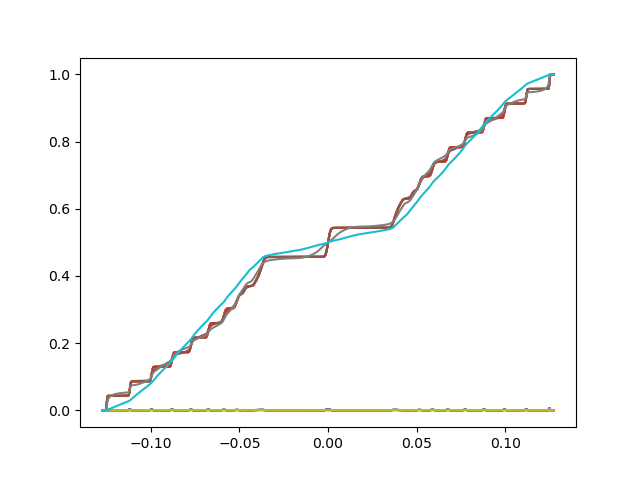

In [43]:
plt.figure()
for bb in range(len(bin_ldos)):
    plt.plot(bin_ldos[bb][0],bin_ldos[bb][1])
    plt.plot(bin_ldos[bb][0],[np.sum(bin_ldos[bb][1][:idx]) for idx in range(len(bin_ldos[bb][0]))])
plt.show()

In [9]:
ldostest=fsc.qsystem.sample_ldos(Ncore=10)

/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/quantum_solvers/default_solver.py:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  site_in_b=np.array([np.where((site_radii >= bins[b]) & (site_radii < bins[b+1]))[0] for b in range(num_sample)])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [27]:
fsc.update_Poisson()

In [9]:

data=sio.loadmat("/scratch/zhaoyuha/Datas/EQuantum_data/topgate/test0003_06")
Uis=data['Uis']
nis=data['nis']

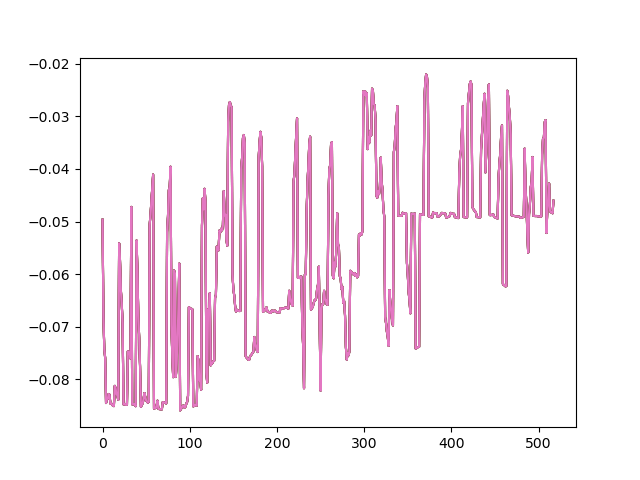

In [11]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.01 and fsc.sites[idx].material=='Qsystem']
plt.figure()
for Uii in Uis:
    plt.plot(Uii[cut_idx])
plt.show()